In [ ]:
""" revenue in millions """

In [1]:
import tqdm
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
print(tf.__version__)

2.8.0


In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
from keras.models import Sequential

In [4]:
from utils import cd_root_dir, sin_transformer, cos_transformer, save2Vis
from modules import pl_preds_uncertainty, plot_history_info, EnsemblePredict, cp_dp_PI_bound, show_dist
from models import build_and_compile_model, create_and_compile_aleatoric_model, build_lstm, compile_and_fit_lstm, build_BLSTM_svi
from pipeline import import_data, base_process_data, feature_normalization, ensemble_predict, temporal_process_data
from windowing import WindowGenerator
from models import sg_prior, nll, BDNN_svi, BDNN_flipout, build_BLSTM_svi2, lstm_SRT

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.6.1


In [6]:
# set up a global plt style for the script
plt.style.use('classic')
plt.rcParams.update({
        "font.size": 9,
        "text.usetex": True,
        "font.family": "serif",
        "figure.figsize": (4, 3),
        "legend.fontsize": 'medium',
        })

In [7]:
%matplotlib widget
%load_ext rich

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
tf.random.set_seed(9527)

In [10]:
cd_root_dir()

current directory: /home/yuchen/work_leslie/KTP_Croud


In [11]:
# dummy xaxis 
val_x_axis = np.arange(200, 208)

# import the data

In [12]:
# import the data and get the time axis !
dataset, time_axis = import_data(path='data/raw/weekly_media_sample.csv')

In [13]:
type(time_axis)

<class 'pandas.core.series.Series'>

In [14]:
time_axis.head()

0    06/08/2012
1    13/08/2012
2    20/08/2012
3    27/08/2012
4    03/09/2012
Name: DATE, dtype: object

In [15]:
time_axis = pd.to_datetime(time_axis, format='%d/%m/%Y')

In [16]:
# plot the val results
val_x_axis = np.arange(200, 208)

In [17]:
dataset.tail()

,revenue,media1_S,media2_S,media3_S,competitor_sales,newsletter
203,2456240.000,0.0,153723.66670,0.0000,7612762,28157.00
204,2182825.000,154917.6,0.00000,133624.5755,6701667,10644.00
205,2377706.667,21982.5,17476.00000,0.0000,7688920,9597.00
206,2732825.000,22453.0,24051.33333,0.0000,8815710,90189.00
207,2767788.333,0.0,0.00000,366190.7594,9067759,19401.65


# Explanatory of dataset

In [ ]:
dataset.describe().transpose()

In [ ]:
plot_features = dataset.copy()
plot_features.index = time_axis
_ = plot_features.plot(subplots=True)

In [ ]:
# # plot
# sns.pairplot(dataset[['revenue', 'media1_S', 'media2_S', 'media3_S']], diag_kind='kde')

In [ ]:
# sns.pairplot(dataset[['newsletter', 'media1_S', 'media2_S', 'media3_S']], diag_kind='kde')

# `base` processing the dataset into *train, val*

In [ ]:
# a given split
train_features, test_features, train_labels, test_labels = base_process_data(dataset=dataset, split_index=200)

In [ ]:
# double check tbe given split

print(dataset.iloc[200-1])
print(time_axis[200-1])

In [ ]:
train_features.shape
train_labels.shape
test_features.shape
test_labels.shape

In [ ]:
# feature normalization
normalizer = feature_normalization(train_features)

# Modelling


## base models

### a deterministic DNN model as `reference`

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1,
    epochs=300)

In [ ]:
plot_history_info(history)

In [ ]:
dnn_model.evaluate(test_features, test_labels)

### an aleatoric DNN model that computes `data noise`

In [ ]:
aleatoric_model = create_and_compile_aleatoric_model(
                        input_shape = 5, 
                        norm = normalizer)

In [ ]:
history_aleatoric = aleatoric_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=300)

In [ ]:
plot_history_info(history_aleatoric)

In [ ]:
aleatoric_model.evaluate(test_features, test_labels)

In [ ]:
# model prediction with aleatoric model
y_model = aleatoric_model(test_features)

y_hat = y_model.mean()
y_hat_m2sd = y_hat - 2 * y_model.stddev()
y_hat_p2sd = y_hat + 2 * y_model.stddev()

In [ ]:
tf.keras.metrics.mean_absolute_error(
    y_true=test_labels, y_pred=np.squeeze(y_hat))

In [ ]:
tf.keras.metrics.mean_absolute_percentage_error(
    y_true=test_labels, 
    y_pred=np.squeeze(y_hat))

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

# plot the train and val [revenue] series 
ax.plot(dataset.revenue, marker='+')

# boundry between train and val
ax.axvline(x=200, ymin=0, ymax=1, color='purple', linestyle='--')

val_x_axis = np.arange(200, 208)

# add the predictions then 
ax.scatter(val_x_axis, test_labels, color='r', marker='o', )

ax.fill_between(val_x_axis,
        np.squeeze(y_hat_p2sd),
        np.squeeze(y_hat_m2sd), 
        color='salmon', 
        alpha=0.2, 
        label='95CI')

ax.grid(linestyle=':')
ax.set_xlim([160,208])
ax.set_ylabel('Revenue in million')
ax.legend(loc='best')

In [ ]:
# val range only

fig, ax = plt.subplots()

val_x_axis = np.arange(0, 8)

# gt
ax.scatter(val_x_axis, test_labels, marker='o', alpha=0.4, label='gt')


# mean prediction
ax.plot(val_x_axis, y_hat, color='blue', label='conditional mean')
ax.plot(val_x_axis, y_hat_m2sd, 'g--', label='95 aleatoric interval')
ax.plot(val_x_axis, y_hat_p2sd, 'g--')
ax.legend()

ax.set_ylabel('Revenue')        
ax.set_xlabel('validation')
ax.set_title('Aleatoric uncertainy')
# ax.set_ylim([0, 6])

save2Vis('DNN_aleatoric')

### Construct a BNN model

In [ ]:
B_model = BDNN_svi(norm=normalizer, N = 200)

In [ ]:
B_model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(), metrics=['mae'])

In [ ]:
BNN_history = B_model.fit(
    train_features,
    train_labels,
    validation_data = (test_features, test_labels),
    batch_size = 64,
    verbose=1, 
    epochs=100,
)

In [ ]:
plot_history_info(BNN_history)

In [ ]:
# okay a bit noisy .. anyway ... let's do inference 

In [ ]:
ensemble = EnsemblePredict(ensemble_size=300, test_features = test_features, test_labels=test_labels)

In [ ]:
# epistemic uncertainty 
# compute the ensemble times of conditional mean ... 
ensemble.mc_predict_test_set(model=B_model)

In [ ]:
# plot the epistemic uncertainty 
ensemble.pl_epistemic(val_x_axis = val_x_axis)

In [ ]:
# mixed uncertainty: compute the distribution objects throughout the test set for 

ensemble.cp_ensemble_testset(B_model)

In [ ]:
len(ensemble._dist_obj_testset)
PI_dp_bounds_all_list = ensemble.get_PI_bounds_testset(style='gmm')
PI_dp_bounds_all_list[0]
B_model.evaluate(test_features, test_labels)

In [ ]:
tf.keras.metrics.mean_absolute_error(y_true=test_labels, y_pred=np.mean(ensemble.enPred_WholeTestSet, axis=0))

<font color='red'>TODO</font> Plot the mixed uncertainty and also the distribution w.r.c a certain data point.

### Flipout model

In [ ]:
flipout_model = BDNN_flipout(N=200, norm=normalizer)

In [ ]:
flipout_model.compile(
    loss=nll, 
    optimizer='RMSprop',
    metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae'),
            tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])

history_flipout = flipout_model.fit(
                    train_features,
                    train_labels,
                    epochs=300,
                    validation_split=0.2,
                    verbose=1)

In [ ]:
plot_history_info(history_flipout)

In [ ]:
# Bayesian changing each time
flipout_model.evaluate(train_features, train_labels)

In [ ]:
ensemble = EnsemblePredict(ensemble_size=300, test_features = test_features, test_labels=test_labels)

In [ ]:
# epistemic uncertainty 
# compute the ensemble times of conditional mean ... 
ensemble.mc_predict_test_set(model=flipout_model)

In [ ]:
# plot the epistemic uncertainty 
ensemble.pl_epistemic(val_x_axis = val_x_axis)

In [ ]:
ensemble.pl_epistemic_ts(dataset=dataset)
save2Vis('BDNN_epistemic_uncertainty')

In [ ]:
mae, mape = ensemble.cp_ensemble_metrics()

In [ ]:
mae

In [ ]:
mape

In [ ]:
# mixed uncertainty plot ...

In [ ]:
# mixed uncertainty: compute the distribution objects throughout the test set for 

ensemble.cp_ensemble_testset(flipout_model)

In [ ]:
# compute the GMM bounds given dist objects

PI_dp_bounds_all_list = ensemble.get_PI_bounds_testset(style='gmm')

In [ ]:
PI_dp_bounds_all_list[0].mean

In [ ]:
ensemble.mixed_uncertainty_PI(dataset, PI_dp_bounds_all_list, val_x_axis)
save2Vis('mixed_uncertainty')

### `PYMC` Bayesian linear regression model

In [ ]:
RANDOM_SEED = 9527
rng = np.random.default_rng(RANDOM_SEED)

In [ ]:
# normalized features
n_train_features, n_test_features, train_labels, test_labels = base_process_data(dataset=dataset, split_index=200, normalize=True)

In [ ]:
train_labels.shape

In [ ]:
n_train_features.shape

In [ ]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = Normal("sigma", 0, sigma=10)
    
    b1 = Normal("media1_S", 0, sigma=1)
    b2 = Normal("media2_S", 0, sigma=1)
    b3 = Normal("media3_S", 0, sigma=1)
    b_cs = Normal("competitor_sales", 0, sigma=1)
    b_nl = Normal("newsletter", 0, sigma=1)
    bias = Normal("bias", 0, sigma=1)

    # Define likelihood
    likelihood = Normal("revenue", 
                        mu = bias +b1*n_train_features[:,0]+b2*n_train_features[:,1]+b3*n_train_features[:,2]+b_cs*n_train_features[:,3]+b_nl*n_train_features[:,4], 
                        sigma=sigma, 
                        observed=train_labels)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(5000)

In [ ]:
az.plot_trace(idata, combined=True, figsize=(12, 24));

In [ ]:
idata

In [ ]:
# idata.posterior.get('media1_S').to_numpy()
# b1_samples = idata.posterior.media1_S.to_numpy()
# b1_samples[0].shape

In [ ]:
dataset.columns

In [ ]:
for var in  dataset.columns[1:]:
    print(var)

In [ ]:
def get_MCMC_samples(dataset, num):
    """ xxx 

    We designate the firt chain
    """
    samples_by_var = [idata.posterior.get(var).to_numpy()[0] for var in dataset.columns[1:]]
    rnd_sample = [np.random.choice(a=s, size=num, replace=True) for s in samples_by_var]
    return rnd_sample

In [ ]:
samples_by_var = get_MCMC_samples(dataset, 300)

# into 5 * 300

In [ ]:
len(samples_by_var)

In [ ]:
samples_by_var[0].shape

In [ ]:
samples_by_var_np = np.vstack(samples_by_var)
samples_by_var_np.shape

In [ ]:
# show the predictions and the results 

In [ ]:
n_test_features.shape

In [ ]:
test_preds = np.matmul(n_test_features, samples_by_var_np)

In [ ]:
test_preds.shape

In [ ]:
fig, ax = plt.subplots()
ax.scatter(val_x_axis, test_labels, label='gt')
ax.scatter(val_x_axis, test_preds[:, 200], label='pred')
# mean-curve
ax.plot(val_x_axis, np.mean(test_preds, axis=1), label='mean')
ax.legend()

### Bayesian linear model by TF

In [ ]:
from models import sg_prior, posterior, posterior2

In [ ]:
linear = Sequential([
    tfpl.DenseVariational(
        units=1,
        make_prior_fn=sg_prior,
        make_posterior_fn=posterior2,
        use_bias=True,
        kl_weight = 1/200),
])

In [ ]:
# linear.summary()

In [ ]:
linear.compile(loss='mse',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['mae', 'mape'])

In [ ]:
history = linear.fit(
    n_train_features,
    train_labels, 
    validation_split=0.2,
    epochs=300,
    verbose=1)

In [ ]:
linear.evaluate(n_test_features, test_labels)

In [ ]:
ensemble = EnsemblePredict(ensemble_size=300, test_features = n_test_features, test_labels=test_labels)

In [ ]:
# epistemic uncertainty 
# compute the ensemble times of conditional mean ... 
ensemble.mc_predict_test_set(model=linear)

In [ ]:
# plot the epistemic uncertainty 
ensemble.pl_epistemic(val_x_axis = val_x_axis)

In [ ]:
mae, mape = ensemble.cp_d_metrics()

In [ ]:
mae

In [ ]:
mape

In [ ]:
show_dist(linear)

### Deter linear regression by TF

In [ ]:
linear_deter = tf.keras.Sequential([
  tf.keras.layers.Dense(1)])

linear_deter.compile(loss='mse',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['mae', 'mape'])

In [ ]:
history = linear_deter.fit(
    n_train_features,
    train_labels, 
    validation_split=0.2,
    epochs=50,
    verbose=1)

In [ ]:
linear_deter.evaluate(n_test_features, test_labels)

In [ ]:
linear_deter.layers[0].get_weights()

## temporal models

I'll try a Bayesian LSTM model first and a few some other state-of-the-art alternatives for illustration.

Note that this will have a different processing procedure than base models.

In [18]:
''' for plotting of `periodicity` '''

''' need a bit tweak-up '''
# # back-up
# # monthly = sin_transformer(period=4, x=index_time)
# # yearly = sin_transformer(period=4*12, x=index_time)

# # periodicity display

# fig, ax = plt.subplots()
# ax.plot(time_axis, dataset['month_sin'], label = 'monthly periodicity')
# ax.plot(time_axis, dataset['revenue'], label='revenue in millions')
# ax.plot(time_axis, dataset['year_sin'], label = 'yearly periodicity')

# ax.set_xlabel('Time')
# ax.set_ylabel('Revenue')
# ax.legend()

' need a bit tweak-up '

In [19]:
train_df, val_df = temporal_process_data(dataset, split_index=200)

Processed dataset shape:  (208, 7)


In [20]:
train_df.shape

(200, 7)

In [21]:
val_df.shape

(8, 7)

In [25]:
# create a window object

In [26]:
# weekly context length
context_length = 4

cr_window = WindowGenerator(
    input_width=context_length,
    label_width=1,
    shift=1,
    label_columns=['revenue'], 
    train_df=train_df,
    val_df = val_df)

cr_window

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [4]
Label column name(s): ['revenue']

In [27]:
print("shape hint:")
print("input shape:", cr_window.example[0].shape)
print("output shape:", cr_window.example[1].shape)

shape hint:
input shape: (64, 4, 7)
output shape: (64, 1, 1)


### Deterministic LSTM model

#### a DNN test

In [ ]:
def DNN_wo_normalization():
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(2, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    return model

In [ ]:
DNN_wn = DNN_wo_normalization()

In [ ]:
history = compile_and_fit_lstm(
    model = DNN_wn, 
    loss = tf.keras.losses.MeanSquaredError(), 
    window=cr_window, 
    EPOCHS = 100,
    VERBOSE = 1)

In [ ]:
dnn_result_dict = cp_val(DNN_wn, cr_window, train_df, val_df)
dnn_result_dict

### deter LSTM

In [ ]:
# get a LSTM model herein

lstm_model = build_lstm()

In [ ]:
history = compile_and_fit_lstm(
    model = lstm_model, 
    loss = tf.keras.losses.MeanSquaredError(), 
    window=cr_window, 
    EPOCHS=100,
    VERBOSE=1)

In [ ]:
plot_history_info(history)

In [ ]:
# # # this may not work due to the very small size of val data
# lstm_model.evaluate(cr_window.val)

In [ ]:
def cp_val(model, window, train_df, val_df):
    all_normalized_data =  pd.concat([train_df, val_df])
    all_normalized_data = all_normalized_data.values

    preds = np.stack([model(tf.expand_dims(all_normalized_data[i-window.input_width:i, :], axis=0)) for i in range(200, 208)])
    preds = np.squeeze(preds)

    # compute the  MAE
    mae =  tf.keras.metrics.mean_absolute_error(
        y_true = val_df['revenue'], y_pred=preds)
    
    mape = tf.keras.metrics.mean_absolute_percentage_error(
        y_true=val_df['revenue'], 
        y_pred=preds)
    return {'mae': mae, 'mape': mape, 'pred': preds}

In [ ]:
# metric
dict_result = cp_val(lstm_model, cr_window, train_df, val_df)
print("mae result", dict_result['mae'])
print("mape result", dict_result['mape'])

### Blstm_svi2

In [ ]:
cr_window.val.element_spec

In [ ]:
for a, b  in cr_window.val.take(1):
    print(a.shape)

In [ ]:
a[0]

In [ ]:
B_lstm_model2 = build_BLSTM_svi2(latent_dim=16, KL_scaling_factor=200)

In [ ]:
# history_Blstm2 = compile_and_fit_lstm(
#     model=B_lstm_model2, 
#     window = cr_window, 
#     loss = 'mse', 
#     EPOCHS=100,
#     VERBOSE=1)

### Stochastic Regularisation technique

In [28]:
tf.keras.backend.clear_session()

In [29]:
lstm_SRT = lstm_SRT(units=16)

In [30]:
history_Blstm2 = compile_and_fit_lstm(
    model=lstm_SRT, 
    window = cr_window, 
    loss = 'mse', 
    EPOCHS=200,
    VERBOSE=1)

Epoch 1/200
4/4 [==============================] - 3s 193ms/step - loss: 0.8970 - mae: 0.8118 - mape: 116.9518 - val_loss: 0.9277 - val_mae: 0.8879 - val_mape: 88.7072
Epoch 2/200
4/4 [==============================] - 0s 36ms/step - loss: 0.8253 - mae: 0.7786 - mape: 116.8063 - val_loss: 0.8431 - val_mae: 0.8377 - val_mape: 82.8207
Epoch 3/200
4/4 [==============================] - 0s 34ms/step - loss: 0.7663 - mae: 0.7311 - mape: 107.3371 - val_loss: 0.7633 - val_mae: 0.7888 - val_mape: 77.1758
Epoch 4/200
4/4 [==============================] - 0s 38ms/step - loss: 0.6824 - mae: 0.6869 - mape: 105.1715 - val_loss: 0.6849 - val_mae: 0.7374 - val_mape: 71.2615
Epoch 5/200
4/4 [==============================] - 0s 36ms/step - loss: 0.6844 - mae: 0.6861 - mape: 109.6829 - val_loss: 0.6113 - val_mae: 0.6855 - val_mape: 65.2719
Epoch 6/200
4/4 [==============================] - 0s 40ms/step - loss: 0.6418 - mae: 0.6671 - mape: 112.1946 - val_loss: 0.5481 - val_mae: 0.6374 - val_mape: 59.71

In [31]:
# metric
lstm_result_dict2 = cp_val(lstm_SRT, cr_window, train_df, val_df)
lstm_result_dict2

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_19085/2025648206.py:2 in <cell line: 2>                                           │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_19085/2025648206.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'cp_val' is not defined

In [32]:
cr_window.cp_val_lstm_mcdropout_oneshot(model=lstm_SRT)

{
    'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.4044818>,
    'mape': <tf.Tensor: shape=(), dtype=float32, numpy=45.89017>
}

In [39]:
ensemble_results, mae_mean, mape_mean = cr_window.cp_val_B(
    model=lstm_SRT, ensemble_size=100, style='mc_dropout')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.65it/s]


In [40]:
mae_mean

0.362164

In [41]:
mape_mean

39.930233

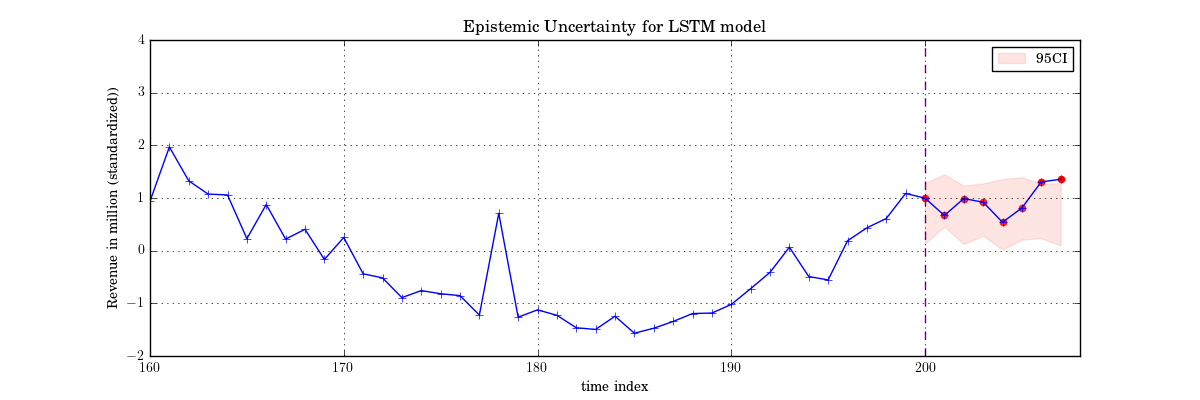

In [35]:
cr_window.display_lstm_val(ensemble_results, val_x_axis)
save2Vis('BLSTM_epistemic_uncertainty')

### Bayesian LSTM model

In [ ]:
''' reference '''

# Flipout_ensem_forecasts = w1.val_fcast_MC_DNN(
#     data=val_df, 
#     model=model_flipout, 
#     ensemble_size=50)

In [ ]:
B_lstm_model = build_BLSTM_svi(latent_dim=16, KL_scaling_factor=200)

In [ ]:
history_Blstm = compile_and_fit_lstm(
    model=B_lstm_model, 
    window = cr_window, 
    loss = nll, 
    EPOCHS=500,
    VERBOSE=1)

In [ ]:
plot_history_info(history_Blstm)

In [ ]:
# check the input 
for ex_input, ex_output in cr_window.val.take(1):
    print("training dp input:", ex_input.shape)
    print("training dp output:", ex_output.shape)

In [ ]:
ensemble_results = cr_window.cp_val(model = B_lstm_model, ensemble_size=300)

In [ ]:
ensemble_results

In [ ]:
# specifically, now the gt value is the normalized 'revenue' shown only in `val_df`

In [ ]:
# add the predictions then 
fig, ax = plt.subplots()
ax.scatter(val_x_axis, val_df['revenue'], color='r', marker='o')
ax.scatter(val_x_axis, test_preds, color='b', marker='x')
# plt.xlim([0, 4])

# metrics

In [ ]:
# deterministic metrics such as ensemble-averaged mae, mape, etc ...

In [ ]:
# uncertainty metrics ...

# pool

In [ ]:
# # loop on each data point

# preds = []
# for i in range(200, 208):
#     pred_dp = lstm_model(tf.expand_dims(all_normalized_data[i-cr_window.input_width:i, :], axis=0))
#     preds.append(pred_dp)

# preds = np.stack(preds)

In [ ]:
# # without normalization

# dnn_model = keras.Sequential([
#   layers.Dense(128, activation='relu', input_shape=(5,)),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(1)
# ])

# dnn_model.compile(loss='mae',
#             optimizer=tf.keras.optimizers.Adam(),
#             metrics=[tf.keras.metrics.MeanAbsolutePercentageError(
#     name='mean_absolute_percentage_error', dtype=None
# )])